In [1]:
!pip install pandas tensorflow tensorflow-hub matplotlib scikit-learn lxml 

     ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
     - -------------------------------------- 0.3/11.6 MB 7.2 MB/s eta 0:00:02
     --- ------------------------------------ 1.1/11.6 MB 11.8 MB/s eta 0:00:01
     ------ --------------------------------- 1.9/11.6 MB 14.9 MB/s eta 0:00:01
     -------- ------------------------------- 2.4/11.6 MB 14.1 MB/s eta 0:00:01
     ---------- ----------------------------- 3.0/11.6 MB 13.7 MB/s eta 0:00:01
     ------------ --------------------------- 3.6/11.6 MB 14.2 MB/s eta 0:00:01
     -------------- ------------------------- 4.2/11.6 MB 14.1 MB/s eta 0:00:01
     ---------------- ----------------------- 4.7/11.6 MB 13.7 MB/s eta 0:00:01
     ------------------ --------------------- 5.2/11.6 MB 13.9 MB/s eta 0:00:01
     ------------------ --------------------- 5.3/11.6 MB 13.6 MB/s eta 0:00:01
     --------------------- ------------------ 6.1/11.6 MB 13.1 MB/s eta 0:00:01
     ----------------------- ---------------- 6.9


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Step 2: Parse XML Files (Convert to CSV)
import os
import pandas as pd
import xml.etree.ElementTree as ET

# Paths
annotations_dir = r"E:\archive\annotations\maksssksksss0.xml"  # adjust if needed

# Create a list to hold annotations
annotations = []

# Loop through all XML files
for filename in os.listdir(annotations_dir):
    if filename.endswith('.xml'):
        tree = ET.parse(os.path.join(annotations_dir, filename))
        root = tree.getroot()
        
        for member in root.findall('object'):
            value = (
                root.find('filename').text,
                int(root.find('size/width').text),
                int(root.find('size/height').text),
                member.find('name').text,
                int(member.find('bndbox/xmin').text),
                int(member.find('bndbox/ymin').text),
                int(member.find('bndbox/xmax').text),
                int(member.find('bndbox/ymax').text)
            )
            annotations.append(value)

# Create a DataFrame
df = pd.DataFrame(annotations, columns=[
    'filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'
])

# Display few rows
df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss0.png,512,366,without_mask,79,105,109,142
1,maksssksksss0.png,512,366,with_mask,185,100,226,144
2,maksssksksss0.png,512,366,without_mask,325,90,360,141
3,maksssksksss1.png,400,156,with_mask,321,34,354,69
4,maksssksksss1.png,400,156,with_mask,224,38,261,73


In [4]:
# Step 3: Split Dataset into Train and Test
from sklearn.model_selection import train_test_split

# Unique filenames
unique_filenames = df['filename'].unique()

# Split
train_filenames, test_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=42)

# Create Train/Test DataFrames
train_df = df[df['filename'].isin(train_filenames)]
test_df = df[df['filename'].isin(test_filenames)]

print(f"Training images: {len(train_filenames)}")
print(f"Testing images: {len(test_filenames)}")

Training images: 682
Testing images: 171


In [5]:
# Step 4: Load Images and Bounding Boxes
import tensorflow as tf

# Set your image directory
images_dir = r"E:\archive\images\maksssksksss0.png"

# Map classes to numbers
class_names = df['class'].unique().tolist()
class_to_id = {name: idx for idx, name in enumerate(class_names)}

print(class_to_id)


{'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}


In [6]:
# Function to Load Images + Labels
def load_image_and_labels(filename, dataframe, images_path):
    # Filter annotations for the file
    records = dataframe[dataframe['filename'] == filename]
    
    # Load image
    img_path = os.path.join(images_path, filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Prepare bounding boxes
    boxes = []
    labels = []
    for _, row in records.iterrows():
        xmin = row['xmin'] / row['width']
        ymin = row['ymin'] / row['height']
        xmax = row['xmax'] / row['width']
        ymax = row['ymax'] / row['height']
        boxes.append([ymin, xmin, ymax, xmax])  # TensorFlow format
        labels.append(class_to_id[row['class']])
    
    return image, (boxes, labels)

In [7]:
# Create Dataset
def create_tf_dataset(filenames, dataframe, images_path):
    images = []
    targets = []
    for filename in filenames:
        img, (boxes, labels) = load_image_and_labels(filename, dataframe, images_path)
        images.append(img)
        targets.append((boxes, labels))
        
    return images, targets

# Create Train and Test datasets
train_images, train_targets = create_tf_dataset(train_filenames, train_df, images_dir)
test_images, test_targets = create_tf_dataset(test_filenames, test_df, images_dir)

In [8]:
# Step 5: Load Pre-trained SSD MobileNet Model
import tensorflow_hub as hub

# Load SSD MobileNet
model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")

print("Model loaded successfully!")

Model loaded successfully!


In [11]:
# Step 0: Preprocess function
def preprocess_image(image):
    """Preprocess input image for SSD MobileNet."""
    image_resized = tf.image.resize(image, (320, 320))
    image_resized = image_resized * 255.0
    input_tensor = tf.cast(image_resized, dtype=tf.uint8)
    input_tensor = tf.expand_dims(input_tensor, 0)
    return input_tensor

# Step 7: Run Model Prediction
# Predict and show results on multiple images
for idx, sample_image in enumerate(train_images[:5]):  # Here [:5] means only first 5 images for demo
    print(f"Processing image {idx+1}")

    # Preprocess
    input_tensor = preprocess_image(sample_image)

    # Run model
    result = model(input_tensor)

    # Convert outputs
    result = {key: value.numpy() for key, value in result.items()}

print(result.keys())


dict_keys(['raw_detection_boxes', 'detection_multiclass_scores', 'detection_classes', 'detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_anchor_indices', 'detection_scores'])


In [13]:
# Step 8: Draw Predictions
import matplotlib.pyplot as plt

def draw_boxes(image, boxes, scores, classes, threshold=0.5):
    image = image.numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    
    for box, score, cls in zip(boxes, scores, classes):
        if score < threshold:
            continue
        ymin, xmin, ymax, xmax = box
        width, height = xmax - xmin, ymax - ymin
        rect = plt.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                             width * image.shape[1],
                             height * image.shape[0],
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin * image.shape[1], ymin * image.shape[0], f"{int(cls)}: {score:.2f}",
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

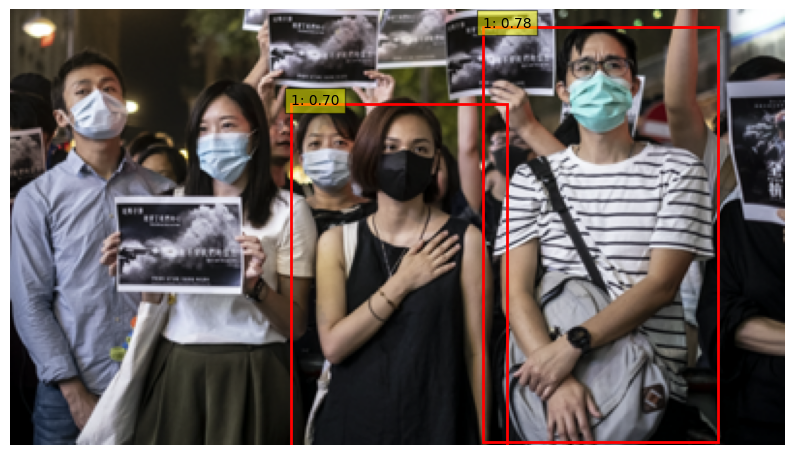

In [14]:
# Draw results
draw_boxes(sample_image, result['detection_boxes'][0], result['detection_scores'][0], result['detection_classes'][0])